In [1]:
import torch
import torch.nn as nn
import numpy as np

class MLP(nn.Module):
    """
    a simple MLP with two hidden layers
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [8]:
class CustomDataLoader:
    """
    A custom data loader that subsamples the mini-batch based on high error. The MSELoss is used as 
    the loss function since this is a regression problem. The error is computed for each example in
    the mini-batch using the loss, the examples are sorted based on the error, and a subset of 
    examples with high error is selected. The subsample_fraction hyperparameter determines the 
    fraction of examples to keep.
    """
    def __init__(self, dataset, batch_size, subsample_fraction):
        """
        Args:
        - dataset: a PyTorch Dataset object
        - batch_size: an integer indicating the batch size
        - subsample_fraction: a float between 0 and 1 indicating the fraction of examples to use for 
            backpropagation
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.subsample_fraction = subsample_fraction
        
    def __iter__(self):
        """
        Returns an iterator that generates subsampled minibatches from the dataset.
        """
        indices = torch.randperm(len(self.dataset))
        for start in range(0, len(self.dataset), self.batch_size):
            end = min(start + self.batch_size, len(self.dataset))
            inputs, targets = self.dataset[indices[start:end]]
            # Iterates over the dataset and generates mini-batches starting from the index start to 
            # end, where start and end are defined by the batch size and the length of the dataset. 
            # The inputs and targets of the mini-batch are extracted from the dataset using 
            # the indices generated by indices[start:end].
            
            with torch.no_grad():
                # torch.no_grad() used to turn off autograd for the duration of a block of code.
                
                # Forward pass to obtain outputs and compute loss
                outputs = model(inputs)
                batch_loss = np.square(outputs - targets).numpy() # calculate squared error
                sorted_idx = np.argsort(batch_loss, axis=0)[::-1]
                #print(sorted_idx)
                    # np.argsort() returns the indices that would sort an array. 
                    # np.argsort([3, 1, 4, 2]) would return [1, 3, 0, 2]
                    # [-1:] changes order of indices to descending order of error.
                    # the result is the array of indices that correspond to the examples with the 
                    # highest errors in the current minibatch
                subset_idx = sorted_idx[:int(len(sorted_idx) * self.subsample_fraction)]
                #print(subset_idx)
                    # selects a subset of these indices based on the subsample_fraction parameter,
                    # and the resulting subset_idx array is used to obtain a subset of the inputs 
                    # and targets for backpropagation.

            # Yield subsampled inputs and targets
            yield inputs[subset_idx.flatten()], targets[subset_idx.flatten()]

A randomly generated dataset is used for demonstration purposes, where each example has 10 features and 1 target value. We're using the custom data loader with a batch size of 32 and a subsample fraction of 0.5. The optimizer used is stochastic gradient descent with a learning rate of 0.1. We train the model for 10 epochs.

Epoch 0: train_loss = 1.0997
Epoch 0: train_loss = 1.5548
Epoch 0: train_loss = 1.6856
Epoch 0: train_loss = 2.9543
Epoch 0: train_loss = 1.5344
Epoch 0: train_loss = 2.4686
Epoch 0: train_loss = 2.6618
Epoch 0: train_loss = 2.1769
Epoch 0: train_loss = 2.8983
Epoch 0: train_loss = 1.2791
Epoch 0: train_loss = 1.9643
Epoch 0: train_loss = 2.4147
Epoch 0: train_loss = 2.4975
Epoch 0: train_loss = 2.2912
Epoch 0: train_loss = 1.9271
Epoch 0: train_loss = 2.0789
Epoch 0: train_loss = 2.7602
Epoch 0: train_loss = 1.6864
Epoch 0: train_loss = 2.0020
Epoch 0: train_loss = 2.4080
Epoch 0: train_loss = 3.0209
Epoch 0: train_loss = 1.8678
Epoch 0: train_loss = 1.8971
Epoch 0: train_loss = 1.8933
Epoch 0: train_loss = 1.6081
Epoch 0: train_loss = 2.3822
Epoch 0: train_loss = 2.4156
Epoch 0: train_loss = 1.8959
Epoch 0: train_loss = 1.9389
Epoch 0: train_loss = 1.2359
Epoch 0: train_loss = 1.8395
Epoch 0: train_loss = 1.3069


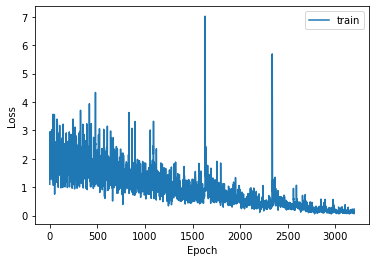

In [13]:
# Set up the model, data, and optimizer
model = MLP(input_size=10, hidden_size=64, output_size=1)
train_dataset = torch.utils.data.TensorDataset(torch.randn(1000, 10), torch.randn(1000, 1))
# creates a PyTorch TensorDataset object that contains 1000 randomly generated input-target pairs. 
# The input tensor has a shape of (1000, 10) (1000 examples with 10 input features), and the target
# tensor has a shape of (1000, 1) (1000 examples with 1 target value).

train_loader = CustomDataLoader(train_dataset, batch_size=32, subsample_fraction=0.5)
# creates a custom data loader object (train_loader) based on the CustomDataLoader class 
# defined earlier. The train_loader object is initialized with the train_dataset object created in 
# the previous line, a batch size of 32, and a subsample fraction of 0.5. This means that each 
# minibatch will consist of 32 examples, and during each training iteration, only the top 50% of 
# examples with the highest errors will be used for backpropagation.

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# reates a stochastic gradient descent (SGD) optimizer object that will be used to update the model 
# parameters during training. 

import matplotlib.pyplot as plt

# Initialize lists to store training loss and validation loss
train_losses = []
val_losses = []

# Train the model
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.MSELoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        # Append training loss to list
        train_losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: train_loss = {train_losses[-1]:.4f}")
        
# Plot training and validation loss
plt.plot(train_losses, label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()